### Homework session 5 _ Group 6
Members:
- Đỗ Ánh Ly
- Nguyễn Phú Nam
- Phạm Vân Thư
- Nguyễn Vinh Khánh
- Đỗ Hữu Kiên

In [149]:
import nltk
import numpy as np
import pandas as pd
from nltk.corpus import twitter_samples
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### Get data

In [150]:
# nltk.download('twitter_samples')
# nltk.download('stopwords')

In [151]:
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

# split data into train and test set
test_pos = all_positive_tweets[4000:]
train_pos = all_positive_tweets[:4000]
test_neg = all_negative_tweets[4000:]
train_neg = all_negative_tweets[:4000]

train_x = train_pos + train_neg 
test_x = test_pos + test_neg

# Create the numpy array of positive labels and negative labels.
train_y = np.append(np.ones((len(train_pos), 1)), np.zeros((len(train_neg), 1)), axis=0)
test_y = np.append(np.ones((len(test_pos), 1)), np.zeros((len(test_neg), 1)), axis=0)

### Data preprocessing

In [152]:
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import re
import string

def process_tweet(tweet):
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')

    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?://[^\s\n\r]+', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)

    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True) #the tokenizer will downcase everything except for emoticons
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and   # remove stopwords
                word not in string.punctuation): # remove punctuation
            stem_word = stemmer.stem(word)
            tweets_clean.append(stem_word)

    return tweets_clean

### Feature engineering

In [153]:
def build_freqs(tweets, ys):
    """ Build frequencies
    Input:
    tweets: a list of tweets
    ys: an mx1 array with the sentiment label of each tweet (either 0 or 1)
    Output:
    freqs: a dictionary mapping each (word, sentiment) pair to its frequency
    """
    yslist = np.squeeze(ys).tolist()
    # start with an empty dict and populate it by looping over all tweets
    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs
freqs = build_freqs(train_x, train_y)

### Feature extraction

In [154]:
def extract_features(tweet, freqs = freqs, process_tweet=process_tweet, train_set_length = len(train_x), normalization = False):
    word_l = process_tweet(tweet)
    
    # 3 elements in the form of a 1 x 3 vector
    x = np.zeros((1, 3)) 
    
    #bias term is set to 1
    x[0,0] = 1    
    # loop through each word in the list of words
    for word in word_l:
        
        # increment the word count for the positive label 1
        if (word, 1) in freqs.keys():
            x[0,1] += freqs[(word, 1)]
        
        # increment the word count for the negative label 0
        if (word, 0) in freqs.keys():
            x[0,2] += freqs[(word, 0)]
        
    assert(x.shape == (1, 3))
    return x


### Logistic regression

In [155]:
def sigmoid(z): 
    h = 1. / (1. + np.exp(-z))
    return h

import matplotlib.pyplot as plt

def gradient_descent_logistic(x, y, theta, alpha, num_iters):
    m = len(x)
    losses = []
    eps = 1e-15
    for i in range(0, num_iters):
        
        # get z, the dot product of x and theta
        z = np.dot(x, theta)
        eps = 1e-15
        
        # get the sigmoid of z
        h = sigmoid(z)
        h_clipped = np.clip(h, eps, 1 - eps)
        # calculate the cost function
        J = - (np.dot(y.T, np.log(h_clipped)) + np.dot((1-y).T, np.log(1-h_clipped))) / float(m)
        losses.append(float(J))
        # update the weights theta
        theta = theta - (alpha * np.dot(x.T, (h-y))) / float(m)
    J = float(J)
    
    # plot the loss function
    iter_list = np.arange(1, num_iters + 1, 1)
    plt.figure(figsize=(5, 3))
    plt.plot(iter_list, losses, color='green', label='loss')
    plt.xlabel('number of iterations')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

    return J, theta
def predict_tweet(tweet, freqs, theta):
    x = extract_features(tweet, freqs)
    # make the prediction using x and theta
    y_pred = sigmoid(np.dot(x, theta))
    
    return y_pred
def test_logistic_regression(test_x, test_y, freqs, theta, predict_tweet=predict_tweet):
    y_hat = list()
    
    for tweet in test_x:
        # get the label prediction for the tweet
        y_pred = predict_tweet(tweet, freqs, theta)
        
        if y_pred > 0.5:
            # append 1.0 to the list
            y_hat.append(1.0)
        else:
            # append 0 to the list
            y_hat.append(0.0)

    accuracy = np.sum(y_hat == np.squeeze(test_y)) / len(test_y)    
    return accuracy


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_26248\175204557.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  losses.append(float(J))
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_26248\175204557.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  J = float(J)


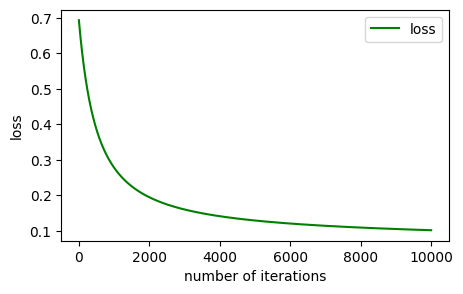

The cost after training is 0.10157921.
The resulting vector of weights is [3e-07, 0.00127323, -0.001111]
Logistic regression model's accuracy = 0.9960


In [156]:
# Result of model scratch
# collect the features 'x' and stack them into a matrix 'X'
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X[i, :]= extract_features(train_x[i], freqs)

# training labels corresponding to X
Y = train_y

# Apply gradient descent
J, w = gradient_descent_logistic(X, Y, np.zeros((3, 1)), 1e-9, 10000)
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(w)]}")
tmp_accuracy = test_logistic_regression(test_x, test_y, freqs, w)
print(f"Logistic regression model's accuracy = {tmp_accuracy:.4f}")


In [157]:
print('Label Predicted Tweet')
countt = 0
for x,y in zip(test_x,test_y):
    y_hat = predict_tweet(x, freqs, w)

    if np.abs(y - (y_hat > 0.5)) > 0:
        print('THE TWEET IS:', x)
        print('THE PROCESSED TWEET IS:', process_tweet(x))
        print('%d\t%0.8f\t%s' % (y, y_hat, ' '.join(process_tweet(x)).encode('ascii', 'ignore')))
        countt += 1
print("The number of error analysis using model scratch", countt)

Label Predicted Tweet
THE TWEET IS: @msarosh Uff Itna Miss karhy thy ap :p
THE PROCESSED TWEET IS: ['uff', 'itna', 'miss', 'karhi', 'thi', 'ap', ':p']
1	0.47137167	b'uff itna miss karhi thi ap :p'


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_26248\781834869.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('%d\t%0.8f\t%s' % (y, y_hat, ' '.join(process_tweet(x)).encode('ascii', 'ignore')))


THE TWEET IS: @phenomyoutube u probs had more fun with david than me : (
THE PROCESSED TWEET IS: ['u', 'prob', 'fun', 'david']
0	0.53251630	b'u prob fun david'
THE TWEET IS: pats jay : (
THE PROCESSED TWEET IS: ['pat', 'jay']
0	0.50095500	b'pat jay'
THE TWEET IS: @bae_ts WHATEVER STIL L YOUNG &gt;:-(
THE PROCESSED TWEET IS: ['whatev', 'stil', 'l', 'young', '>:-(']
0	0.50032454	b'whatev stil l young >:-('
THE TWEET IS: my beloved grandmother : ( https://t.co/wt4oXq5xCf
THE PROCESSED TWEET IS: ['belov', 'grandmoth']
0	0.50000008	b'belov grandmoth'
THE TWEET IS: @CHEDA_KHAN Thats life. I get calls from people I havent seen in 20 years and its always favours : (
THE PROCESSED TWEET IS: ['that', 'life', 'get', 'call', 'peopl', 'havent', 'seen', '20', 'year', 'alway', 'favour']
0	0.50564988	b'that life get call peopl havent seen 20 year alway favour'
THE TWEET IS: Sr. Financial Analyst - Expedia, Inc.: (#Bellevue, WA) http://t.co/ktknMhvwCI #Finance #ExpediaJobs #Job #Jobs #Hiring
THE PROCES

### Ex1: Make use of Logistic Regression model from scikit-learn or some other packages in Python, run the Sentiment Analysis solution again and make a very thorough comparison with what we implemented from scratch.

In [158]:
# Result from LogisticRegresison from sklearn
from sklearn.metrics import accuracy_score, log_loss, classification_report
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X, Y)
print(logreg.intercept_,logreg.coef_)
x_test = np.zeros((len(test_x), 3))
for i in range(len(test_x)):
    x_test[i, :]= extract_features(test_x[i], freqs)
y_pred = logreg.predict(x_test)
acc = accuracy_score(test_y, y_pred)

print(f"Logistic regression model's accuracy = {acc:.4f}")

y_prob = logreg.predict_proba(x_test)   # xác suất dự đoán
cost = log_loss(test_y, y_prob)
print(f"Cost = {cost:.6f}")
print()
report = classification_report(test_y, y_pred)
print(report)

[0.23910221] [[ 0.23908787  0.00827686 -0.00966569]]


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic regression model's accuracy = 0.9950
Cost = 0.015098

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      1000
         1.0       0.99      1.00      1.00      1000

    accuracy                           0.99      2000
   macro avg       1.00      0.99      0.99      2000
weighted avg       1.00      0.99      0.99      2000



[[992   8]
 [  2 998]]


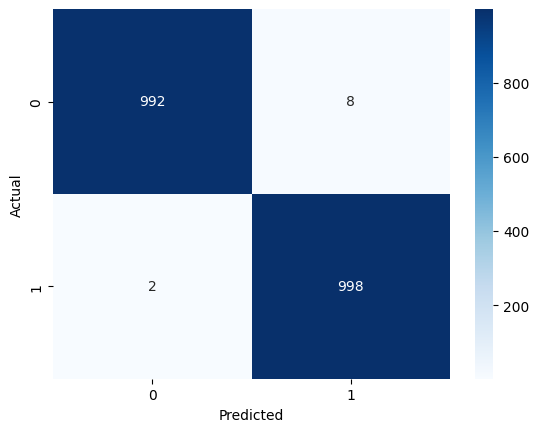

In [159]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# y_true: nhãn thật
# y_pred: nhãn dự đoán từ model
y_pred = logreg.predict(x_test)

# Tạo confusion matrix
cm = confusion_matrix(test_y, y_pred)
print(cm)

# Visualize
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [160]:
# Lấy xác suất dự đoán cho class 1
y_hat= y_prob[:, 1]

# Chuyển xác suất sang nhãn 0/1
y_pred_labels = (y_hat> 0.5).astype(int)

num = 0
for x, y_true, prob in zip(test_x, test_y, y_pred_labels):
    y_pred_labels = int(prob > 0.5)  
    if y_true != y_pred_labels:
        print('THE TWEET IS:', x)
        print('THE PROCESSED TWEET IS:', process_tweet(x))
        print('True label: %d\tPredicted prob: %0.8f\tPredicted label: %d' % (y_true, prob, y_pred_labels))
        num += 1

print("The number of error analysis using sklearn:", num)


THE TWEET IS: @MarkBreech Not sure it would be good thing 4 my bottom daring 2 say 2 Miss B but Im gonna be so stubborn on mouth soaping ! #NotHavingit :p
THE PROCESSED TWEET IS: ['sure', 'would', 'good', 'thing', '4', 'bottom', 'dare', '2', 'say', '2', 'miss', 'b', 'im', 'gonna', 'stubborn', 'mouth', 'soap', 'nothavingit', ':p']
True label: 1	Predicted prob: 0.00000000	Predicted label: 0
THE TWEET IS: @msarosh Uff Itna Miss karhy thy ap :p
THE PROCESSED TWEET IS: ['uff', 'itna', 'miss', 'karhi', 'thi', 'ap', ':p']
True label: 1	Predicted prob: 0.00000000	Predicted label: 0
THE TWEET IS: @phenomyoutube u probs had more fun with david than me : (
THE PROCESSED TWEET IS: ['u', 'prob', 'fun', 'david']
True label: 0	Predicted prob: 1.00000000	Predicted label: 1
THE TWEET IS: @bumkeyyfel b-butt : ( isn't black cat a bad luck ene
THE PROCESSED TWEET IS: ['b-butt', 'black', 'cat', 'bad', 'luck', 'ene']
True label: 0	Predicted prob: 1.00000000	Predicted label: 1
THE TWEET IS: pats jay : (
THE 

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_26248\4008995557.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('True label: %d\tPredicted prob: %0.8f\tPredicted label: %d' % (y_true, prob, y_pred_labels))


| Criteria       | Sklearn LogisticRegression        | Model Scratch |
|-----------------|-----------------------------------|--------------------------|
| Coefficients    | [0.239, 0.0083, -0.0097]          | [3e-07, 0.00127, -0.0011]|
| Loss           |  0.015098                  | 0.1016                   |
| Accuracy        | 0.9950                            | 0.9960                   |
| Error analysis cases         | 10                         | 8                  |


| Criteria       | Sklearn LogisticRegression        | Model Scratch |
|-----------------|-----------------------------------|--------------------------|
| Training method | Scikit-learn does not run plain GD. Instead, it solves the problem via Maximum Likelihood Estimation (MLE) under the hood. The optimization is performed by advanced solvers like LBFGS, liblinear, saga, etc. These are quasi-Newton methods or coordinate descent algorithms, which are more efficient and numerically stable than vanilla GD. These solvers find the parameter values that maximize the likelihood (equivalently, minimize the negative log-likelihood / cross-entropy). They also natively handle regularization (L1/L2 penalty), which helps prevent overfitting and improves generalization.| We explicitly define the logistic regression cost function (cross-entropy / negative log-likelihood) and minimize it using Gradient Descent (GD).This means at every iteration we compute the gradient of the cost with respect to the weights and update them step by step. The convergence and final performance depend on hyperparameters such as the learning rate and number of iterations.        |
| Convergence speed    | Sklearn converges quickly and stably due to optimized solvers.                             | The scratch model is generally slower and depends on hyperparameters such as learning rate and number of iterations.|
| Roburstness   | Strong, stable, less sensitive with learning rate                | more sensitive and prone to errors if hyperparameters are not well-tuned.|
|Interpretability & Ease of use           | luser-friendly, provides built-in functions for log-loss and accuracy, and supports regularization and multiple solvers|more complex to implement but still allows calculation of log-loss and accuracy, making it suitable for academic exercises or practical learning |
|Error analysis        | Sklearn provide confusion matrix with detailed each cases most of analysis are true mean while there are some cases that sentiment are misslabeled and total mislabeled cases are 10 | less error analysis but we can not see more detail to understand error  |


<p align = 'left'> - About performace :
<p align = 'left'> + The coefficients of Sklearn LogisticRegression and the Scratch Model are both quite small, indicating that each feature has a mild impact on the prediction.
<p align = 'left'> + Sklearn: 0.015098 → lower, meaning the model converged well and has a low error cost on the data.
<p align = 'left'> + Scratch Model: 0.1016 → higher, implying that the manual gradient descent is not as optimized as Sklearn’s solver, though still reasonably low.
<p align = 'left'> + Both models achieve very high accuracy (>99%), showing excellent overall prediction performance.


### Ex2: In this line of code, if we change the number of iterations to, say, 100K, you might get some “divided by zero” error. Explain why and find a correction.
gradientDescent(X, Y, np.zeros((3, 1)), 1e-9, 10000)

<p align="left"> - If changing the number of iterations to 100k, we might get "devided by zero" error because we use gradient descent to update the coefficient, so in logistic regression, the algorithm may converge to a solution where gradient become very small approaching 0. Then, during the computation of the cost function in logistic regression, we take log(y_predict). If y_predict gets extremely close to 0, this leads to evaluating log ⁡( 0 ), which is undefined and causes the error.
<p align = 'left'> - To correct, we have 2 ways:
<p align = 'left'> + Using np.clip(array, min_value, max_value): this function acts like when value < min_value then set the value = min_value and similar to max_value so that the gradient descent can control the range of value and make sure that y_predict won't apprach 0.
<p align = 'left'> + Adding a small constant when computing the log terms to avoid zero: 
<p align = 'center'> J = - (np.dot(y.T, np.log(y_pred + small_cons)) + np.dot((1-y).T, np.log(1-h + small_cons))) / float(m)


### Ex3: In Feature Engineering part, given a sentence s, we build two features: the positive frequency of s and the negative frequency of s. Given a sentence s, normalize these two features with respect to N = train_set_length * the length of s. Compare your result with the original one in the course. Is that normalization a good thing to do?

we add normalization in function of extracting feature as a case in original function extract_features() for short 

In [161]:
def normalize_features(tweet, freqs = freqs, process_tweet = process_tweet, train_set_length = len(train_x)):
    x = extract_features(tweet, freqs) 
    len_s = len(process_tweet(tweet)) 
    N = train_set_length * len_s if (len_s) > 0 else 1
    x[0,1:] = x[0, 1:] / N
    return x

def predict_tweet2(tweet, freqs, theta, normalize_features = normalize_features):
    x = normalize_features(tweet, freqs)
    # make the prediction using x and theta
    y_pred = sigmoid(np.dot(x, theta))
    return y_pred
def test_logistic_regression2(test_x, test_y, freqs, theta, predict_tweet2=predict_tweet2):
    y_hat = list()
    
    for tweet in test_x:
        # get the label prediction for the tweet
        y_pred = predict_tweet2(tweet, freqs, theta)
        
        if y_pred > 0.5:
            # append 1.0 to the list
            y_hat.append(1.0)
        else:
            # append 0 to the list
            y_hat.append(0.0)

    accuracy = np.sum(y_hat == np.squeeze(test_y)) / len(test_y)    
    return accuracy

with small learning rate

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_26248\175204557.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  losses.append(float(J))
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_26248\175204557.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  J = float(J)


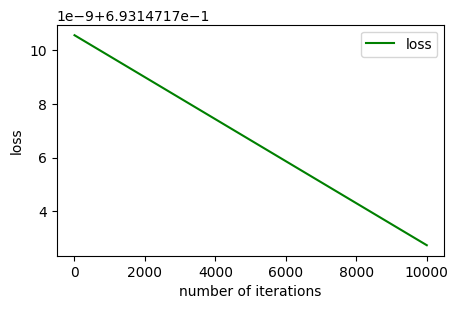

The cost after training with normalization is 0.69314717.
The resulting vector of weights is [0.0, 1.5e-07, -2.3e-07]
Logistic regression model's accuracy with normalization = 0.9895
Label Predicted Tweet
21


In [162]:
X2 = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X2[i, :]= normalize_features(train_x[i])
    
J2, w2 = gradient_descent_logistic(X2, Y, np.zeros((3, 1)), 1e-9, 10000)
print(f"The cost after training with normalization is {J2:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(w2)]}")
tmp_accuracy = test_logistic_regression2(test_x, test_y, freqs, w2)
print(f"Logistic regression model's accuracy with normalization = {tmp_accuracy:.4f}")
print('Label Predicted Tweet')
countt = 0
for x,y in zip(test_x,test_y):
    y_hat = predict_tweet2(x, freqs, w2)
    if np.abs(y - (y_hat > 0.5)) > 0:
        countt+=1
print(countt)

In [163]:
# Compare resutl in predict a sentence
tweet = test_x[1009]
y_pred1 = predict_tweet(tweet, freqs, w)
y_pred2 = predict_tweet2(tweet, freqs, w2)
print(tweet)
print(y_pred1, y_pred2)

:( but wtf am I supposed to do now without her
[[0.01632025]] [[0.49999999]]


with larger learning rate

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_26248\175204557.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  losses.append(float(J))
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_26248\175204557.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  J = float(J)


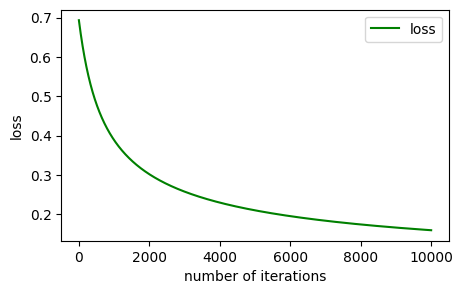

The cost after training with normalization is 0.15929423.
The resulting vector of weights is [0.53374273, 34.01243788, -43.53179106]
Logistic regression model's accuracy with normalization = 0.9695
Label Predicted Tweet
61


In [164]:
X2 = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X2[i, :]= normalize_features(train_x[i])
    
J2, w2 = gradient_descent_logistic(X2, Y, np.zeros((3, 1)), 0.9, 10000)
print(f"The cost after training with normalization is {J2:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(w2)]}")
tmp_accuracy = test_logistic_regression2(test_x, test_y, freqs, w2)
print(f"Logistic regression model's accuracy with normalization = {tmp_accuracy:.4f}")
print('Label Predicted Tweet')
countt = 0
for x,y in zip(test_x,test_y):
    y_hat = predict_tweet2(x, freqs, w2)
    if np.abs(y - (y_hat > 0.5)) > 0:
        countt+=1
print(countt)

In [165]:
# Compare resutl in predict a sentence
tweet = test_x[1009]
y_pred1 = predict_tweet(tweet, freqs, w)
y_pred2 = predict_tweet2(tweet, freqs, w2)
print(tweet)
print(y_pred1, y_pred2)

:( but wtf am I supposed to do now without her
[[0.01632025]] [[0.01105132]]


The probabilities for sentence to be positive are different between model applying normalization to N and original model. While the probability of original model is clearly show the class of sentence's sentiment is negative while the probability of model applying normalization to N is sensitive to the learning rate. With small learning rate, model show high cost with accuracy = 0.985 while one with large learning rate show small cost and accuracy = 0.9695 but with more cases of mislabeled. This is because: 
+ With a small learning rate, the features are very small, so the gradients are also tiny. Weight updates become negligible, the model struggles to learn, and the cost remains high. Surprisingly, accuracy may still look acceptable because logistic regression can default to predicting the majority class. 
+ With larger learning rate, the weight updates are amplified enough to reduce the cost, and probabilities look more “confident.” However, the model may converge to a different solution: accuracy decreases, cost is lower, but generalization is worse, leading to more misclassified cases despite higher confidence in predictions.

||model with normalization to N (small learning rate)| model with normalization to N(large learning rate)|model without normalization to N | 
|-----------------|-----------------------------------|--------------------------|--------------------------|
|Cost|0.69314717| 0.15929423| 0.10157921|
|Weights|[0.0, 1.5e-07, -2.3e-07]|[0.53374273, 34.01243788, -43.53179106]|[3e-07, 0.00127323, -0.001111]|
|Accuracy|0.9895| 0.9695| 0.9960|
|Error analysis|21|61| 8|

=> Normalization is a good method because rescaling features gives them a consistent scale, often between 0 and 1. It can help models converge faster, prevent features with large scales from dominating, and improve performance for distance-based models. However, normalization is not always necessary: tree-based models (like Decision Trees, Random Forests, and Gradient Boosted Trees) often don’t require it, because splits are based on thresholds rather than distances. Similarly, if the features are already on a similar scale, normalization may have little impact. Finally, it is important to choose the most suitable learning rate when scaling data

### Ex4: Apply standard scaling techniques such as min-max scaler, standard scaler, etc to the problem and comment.

In [166]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
std_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_26248\175204557.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  losses.append(float(J))
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_26248\175204557.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  J = float(J)


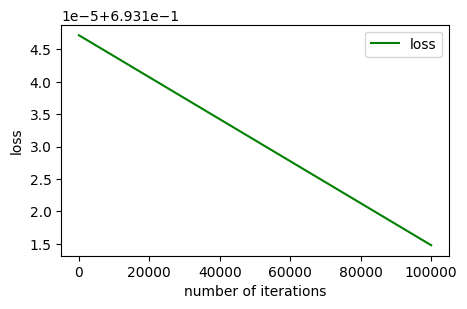

The cost after training is 0.69311476.
The resulting vector of weights is [0.0, 3.793e-05, -4.246e-05]
Logistic regression model's accuracy = 0.9955


In [167]:
#using standard scaler
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X[i, :]= extract_features(train_x[i], freqs)
X_std = std_scaler.fit_transform(X)
Y = train_y
J, w = gradient_descent_logistic(X_std, Y, np.zeros((3, 1)), 1e-9, 100000)
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(w)]}")
Z = test_logistic_regression(test_x, test_y, freqs, w, predict_tweet=predict_tweet)
print(f"Logistic regression model's accuracy = {Z:.4f}")

<p align = 'left'> After using StandardScaler:
<p align = 'left'> - The loss function become relatively linear within 100000 iterations with eta = 1e-8.
<p align = 'left'> - The theta vector become smaller due to scaled data.
<p align = 'left'> - The accuracy drops slightly for 0.05%


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_26248\175204557.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  losses.append(float(J))
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_26248\175204557.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  J = float(J)


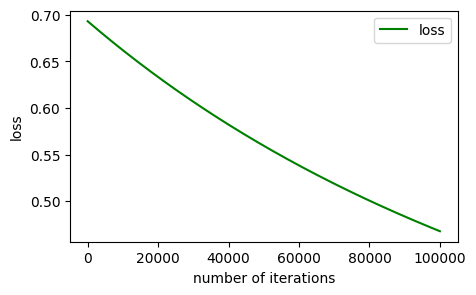

The cost after training is 0.46773037.
The resulting vector of weights is [0.0, 0.31155979, -0.35454645]


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_26248\175204557.py:2: RuntimeWarning: overflow encountered in exp
  h = 1. / (1. + np.exp(-z))


Logistic regression model's accuracy = 0.9955


In [168]:
J, w = gradient_descent_logistic(X_std, Y, np.zeros((3, 1)), 1e-5, 100000)
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(w)]}")
Z = test_logistic_regression(test_x, test_y, freqs, w, predict_tweet=predict_tweet)
print(f"Logistic regression model's accuracy = {Z:.4f}")

<p align = 'left'> When we increase alpha to 1e-5:

<p align = 'left'> - The cost is further decreased.
<p align = 'left'> - The convex of the loss function is more noticeable.
<p align = 'left'>  - The accuracy remain 99.55%

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_26248\175204557.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  losses.append(float(J))
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_26248\175204557.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  J = float(J)


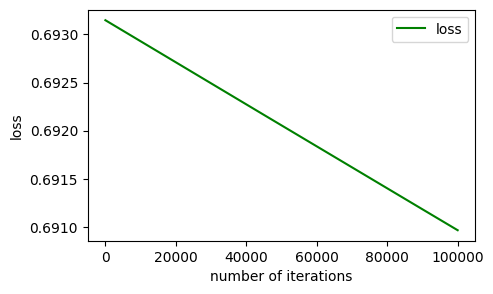

The cost after training is 0.69096633.
The resulting vector of weights is [0.0, 0.02595044, -0.03882589]
Logistic regression model's accuracy = 0.9905


In [169]:
#using MinMax scaler
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X[i, :]= extract_features(train_x[i], freqs)
X_mm = minmax_scaler.fit_transform(X)
Y = train_y
J, w = gradient_descent_logistic(X_mm, Y, np.zeros((3, 1)), 1e-5, 100000)
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(w)]}")
Z = test_logistic_regression(test_x, test_y, freqs, w, predict_tweet=predict_tweet)
print(f"Logistic regression model's accuracy = {Z:.4f}")

Using MinMaxScaler, we notice a 0.5% drop in accuracy comparing to StandardScale

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_26248\175204557.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  losses.append(float(J))
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_26248\175204557.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  J = float(J)


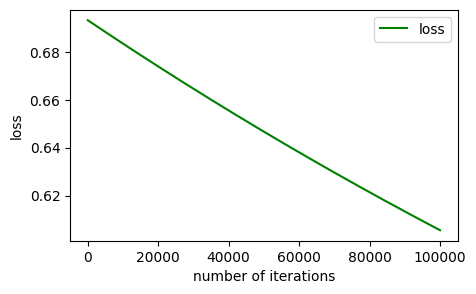

The cost after training is 0.60560120.
The resulting vector of weights is [0.0, 0.19650899, -0.22095362]


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_26248\175204557.py:2: RuntimeWarning: overflow encountered in exp
  h = 1. / (1. + np.exp(-z))


Logistic regression model's accuracy = 0.9955


In [170]:
from sklearn.preprocessing import RobustScaler
rb_scaler = RobustScaler()
#using Robust scaler
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X[i, :]= extract_features(train_x[i], freqs)
X_rb = rb_scaler.fit_transform(X)
Y = train_y
J, w = gradient_descent_logistic(X_rb, Y, np.zeros((3, 1)), 1e-5, 100000)
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(w)]}")
Z = test_logistic_regression(test_x, test_y, freqs, w, predict_tweet=predict_tweet)
print(f"Logistic regression model's accuracy = {Z:.4f}")

RobustScaler gives the equal accuracy comparing to StandardScaler at 99.55%.

### Ex5: During the session, I gave a natural way to end up with Logistic Regression as the decision function for our Sentiment Analysis problem. Let’s come up with another decision function. Let 
$$ 𝑔(𝑠) = \begin{cases}
1 & \text{if positive frequency $>$ negative frequency}\\
0 & \text{𝑜𝑡ℎ𝑒𝑟𝑤𝑖𝑠𝑒}
\end{cases}$$
Note that g(s) =1 means the sentence s has positive sentiment.
With such mathematical formulation, recompute the precision on the test set. Compare and Explain.

In [171]:
def frequency_based(tweet, freqs, process_tweet=process_tweet):
    word_l = process_tweet(tweet)
    pos_count = sum(freqs.get((w, 1.0), 0) for w in word_l)
    neg_count = sum(freqs.get((w, 0.0), 0) for w in word_l)
    return 1 if pos_count > neg_count else 0

In [172]:
def test_frequency_based(test_x, test_y, freqs, process_tweet=process_tweet):
    y_hat = list()
    
    for tweet in test_x:
        y_pred = frequency_based(tweet, freqs, process_tweet)
        y_hat.append(y_pred)
    
    accuracy = np.sum(y_hat == np.squeeze(test_y)) / len(test_y)    
    return accuracy

In [173]:
tmp_accuracy = test_logistic_regression(test_x, test_y, freqs, w)
freq_accuracy = test_frequency_based(test_x, test_y, freqs)
print(f"Logistic regression model's accuracy = {tmp_accuracy:.4f}")
print(f"Frequency-based model's accuracy = {freq_accuracy:.4f}")

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_26248\175204557.py:2: RuntimeWarning: overflow encountered in exp
  h = 1. / (1. + np.exp(-z))


Logistic regression model's accuracy = 0.9955
Frequency-based model's accuracy = 0.9965


Comparison and Explain
- Frequency-based model suprisingly perform a little bit better than a more complicated model as Logistic Regression
- Frequency-based model work well since most of dataset is short tweet that contain clearly positive or negative word
- While logistic regression model learning weight of words that make this model way more generalizable
- On a harder dataset, maybe the Logistic Regression may outform a such simple model as frequency-based

### Ex6: In the course, we considered only two features to solve the problem. Let’s rerun the solution with 4 more features (6 in total) 

### For model 2 features

In [174]:
def extract_2_features(tweet, freqs, process_tweet=process_tweet): #use for 2-feature model
    '''
    Input: 
        tweet: a list of words for one tweet
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
    Output: 
        x: a feature vector of dimension (1,3)
    '''
    # process_tweet tokenizes, stems, and removes stopwords
    word_l = process_tweet(tweet)
    
    # 3 elements in the form of a 1 x 3 vector
    x = np.zeros((1, 3)) 
    
    #bias term is set to 1
    x[0,0] = 1    
    # loop through each word in the list of words
    for word in word_l:
        
        # increment the word count for the positive label 1
        if (word, 1) in freqs.keys():
            x[0,1] += freqs[(word, 1)]
        
        # increment the word count for the negative label 0
        if (word, 0) in freqs.keys():
            x[0,2] += freqs[(word, 0)]
        
    assert(x.shape == (1, 3))
    return x

In [175]:
def predict_tweet_w2ft(tweet, freqs, theta): #use for 2-feature model
    '''
    Input: 
        tweet: a string
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
        theta: (3,1) vector of weights
    Output: 
        y_pred: the probability of a tweet being positive or negative
    '''

    # extract the features of the tweet and store it into x
    x = extract_2_features(tweet, freqs)
    # make the prediction using x and theta
    y_pred = sigmoid(np.dot(x, theta))
    
    return y_pred

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_26248\175204557.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  losses.append(float(J))
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_26248\175204557.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  J = float(J)


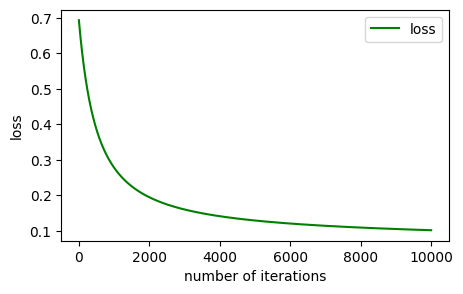

The cost after training is 0.10157921.
The resulting vector of weights is [3e-07, 0.00127323, -0.001111]


In [176]:
# collect the features 'x' and stack them into a matrix 'X'
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X[i, :]= extract_2_features(train_x[i], freqs)

# training labels corresponding to X
Y = train_y

# Apply gradient descent
J, w = gradient_descent_logistic(X, Y, np.zeros((3, 1)), 1e-9, 10000)
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(w)]}")

### For 6-feature model

In [177]:
# Unscaled data
def extract_six_features(tweet, freqs, process_tweet=process_tweet): #use for 6-feature model
    '''
    Input: 
        tweet: a list of words for one tweet
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
    Output: 
        x: a feature vector of dimension (1,3)
    '''
    # process_tweet tokenizes, stems, and removes stopwords
    word_l = process_tweet(tweet)
    
    
    first_second_pronouns = {'i', 'me', 'myself', 
                            'we', 'us',  'ourself', 'ourselves',
                            'you', 'yourself', 'yourselves'}
    

    # 7 elements in the form of a 1 x 7 vector
    x = np.zeros((1, 7)) 
    
    #bias term is set to 1
    x[0,0] = 1    
    # loop through each word in the list of words
    for word in word_l:
        
        # increment the word count for the positive label 1 (feature 1)
        if (word, 1) in freqs.keys():
            x[0,1] += freqs[(word, 1)]
        
        # increment the word count for the negative label 0 (feature 2)
        if (word, 0) in freqs.keys():
            x[0,2] += freqs[(word, 0)]

        # increment the word count for the pronouns (feature 4)
        if word in first_second_pronouns:
            x[0,4] += 1
        
    #determine the boolean value for the presence of 'no' (feature 3)
    x[0,3] = 1 if 'no' in word_l else 0

    #determine the boolean value for the presence of '!' (feature 5)
    x[0,5] = 1 if '!' in tweet else 0
        
    #determine the length of the tweet (feature 6)
    x[0,6] = np.log(len(word_l) + 1) #add 1 to avoid log(0)

        
    assert(x.shape == (1, 7))
    return x

In [178]:
def predict_tweet_w6ft(tweet, freqs, theta): #use for 2-feature model
    '''
    Input: 
        tweet: a string
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
        theta: (3,1) vector of weights
    Output: 
        y_pred: the probability of a tweet being positive or negative
    '''

    # extract the features of the tweet and store it into x
    x = extract_six_features(tweet, freqs)
    # make the prediction using x and theta
    y_pred = sigmoid(np.dot(x, theta))
    
    return y_pred

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_26248\175204557.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  losses.append(float(J))
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_26248\175204557.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  J = float(J)


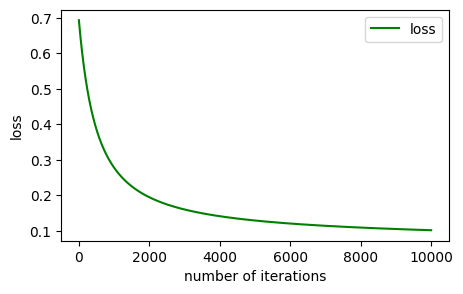

The cost after training is 0.10157920.
The resulting vector of weights is [3e-07, 0.00127323, -0.001111, 0.0, 1e-08, 1.5e-07, 5.7e-07]


In [179]:
# collect the features 'x' and stack them into a matrix 'X'
X = np.zeros((len(train_x), 7))
for i in range(len(train_x)):
    X[i, :]= extract_six_features(train_x[i], freqs)

# training labels corresponding to X
Y = train_y

# Apply gradient descent
J_six, w_six = gradient_descent_logistic(X, Y, np.zeros((7, 1)), 1e-9, 10000)
print(f"The cost after training is {J_six:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(w_six)]}")

In [180]:
Z = test_logistic_regression(test_x, test_y, freqs, w_six, predict_tweet=predict_tweet_w6ft)
print(f"Logistic regression model's accuracy = {Z:.4f}")

Logistic regression model's accuracy = 0.9960


### 6-feature model with scaling data

In [181]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_26248\175204557.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  losses.append(float(J))
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_26248\175204557.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  J = float(J)


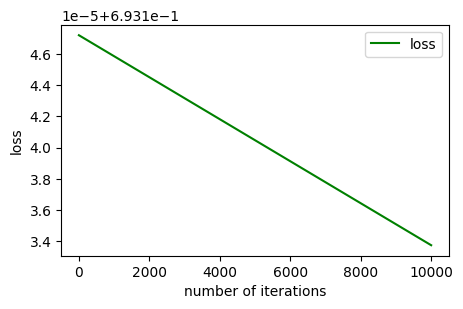

The cost after training is 0.69313375.
The resulting vector of weights is [0.0, 7.59e-06, -8.49e-06, 0.0, 5.9e-07, 2.04e-06, 3.1e-07]


In [182]:
X = np.zeros((len(train_x), 7))
for i in range(len(train_x)):
    X[i, :]= extract_six_features(train_x[i], freqs)

Y = scaler.fit_transform(train_y)

X = scaler.fit_transform(X)

J, w_scaled = gradient_descent_logistic(X, Y, np.zeros((7, 1)), 1e-9, 10000)
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(w_scaled)]}")

In [183]:
Z = test_logistic_regression(test_x, test_y, freqs, w_scaled, predict_tweet=predict_tweet_w6ft)
print(f"Logistic regression model's accuracy = {Z:.4f}")

Logistic regression model's accuracy = 0.9950


### Ex7: In your opinion, can we do better? I propose that your team try all ML models that you know and give us the model with the best possible precision.

In [184]:
import time
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import precision_score, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [185]:
X_test = np.zeros((len(test_x), 7))
for i in range(len(test_x)):
    X_test[i, :] = extract_six_features(test_x[i], freqs)[0]
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

In [186]:
# CV setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Pipelines (scale built-in)
pipelines = {
    "Logistic Regression": Pipeline([("scaler", StandardScaler()), ("clf", LogisticRegression(max_iter=3000, random_state=42))]),
    "Linear SVM": Pipeline([("scaler", StandardScaler()), ("clf", LinearSVC(random_state=42))]),
    "KNN": Pipeline([("scaler", StandardScaler()), ("clf", KNeighborsClassifier())]),
    "Decision Tree": Pipeline([("clf", DecisionTreeClassifier(random_state=42))]),
    "Random Forest": Pipeline([("clf", RandomForestClassifier(random_state=42, n_jobs=-1))]),
    "Gaussian NB": Pipeline([("clf", GaussianNB())])
}

# Param grids (tune cho precision)
param_grids = {
    "Logistic Regression": {"clf__C": [0.1, 1, 10], "clf__class_weight": [None, "balanced"]},
    "Linear SVM": {"clf__C": [0.1, 1, 10]},
    "KNN": {"clf__n_neighbors": [3, 5, 7, 11], "clf__weights": ["uniform", "distance"]},
    "Decision Tree": {"clf__max_depth": [None, 10, 20, 40], "clf__min_samples_leaf": [1, 3, 5]},
    "Random Forest": {"clf__n_estimators": [200, 400], "clf__max_depth": [None, 20, 40], "clf__min_samples_leaf": [1, 3]},
    "Gaussian NB": {}
}

rows, best_models = [], {}

# Train trên X từ 6 features, y = train_y.ravel()
for name, pipe in pipelines.items():
    grid = GridSearchCV(pipe, param_grids.get(name, {}), scoring="precision_macro", cv=cv, n_jobs=-1, refit=True)
    t0 = time.perf_counter()
    grid.fit(X, train_y.ravel())  # Không scale thủ công, pipeline làm
    train_time = time.perf_counter() - t0
    
    best_models[name] = grid.best_estimator_
    y_pred = grid.predict(X_test)
    
    prec = precision_score(test_y, y_pred, average='macro', zero_division=0)
    acc = accuracy_score(test_y, y_pred)
    
    rows.append({
        "Model": name,
        "CV Precision (mean)": round(grid.best_score_, 4),
        "Test Precision": round(prec, 4),
        "Test Accuracy": round(acc, 4),
        "Best Params": grid.best_params_,
        "Train Time (s)": round(train_time, 3)
    })

df = pd.DataFrame(rows).sort_values(by=["Test Precision", "CV Precision (mean)"], ascending=False).reset_index(drop=True)
display(df)

# Best model
best_name = df.iloc[0]["Model"]
print(f"Mô hình tốt nhất theo Test Precision: {best_name}")
print("Best Params:", df.iloc[0]["Best Params"])
print(classification_report(test_y, best_models[best_name].predict(X_test), digits=4))

,Model,CV Precision (mean),Test Precision,Test Accuracy,Best Params,Train Time (s)
0,KNN,0.9928,0.9960,0.9960,"{'clf__n_neighbors': 5, 'clf__weights': 'dista...",1.083
1,Linear SVM,0.9941,0.9955,0.9955,{'clf__C': 0.1},0.104
2,Logistic Regression,0.9936,0.9940,0.9940,"{'clf__C': 10, 'clf__class_weight': None}",5.725
3,Gaussian NB,0.9857,0.9892,0.9890,{},0.042
4,Decision Tree,0.9933,0.7510,0.5040,"{'clf__max_depth': None, 'clf__min_samples_lea...",0.348
5,Random Forest,0.9946,0.7129,0.5055,"{'clf__max_depth': None, 'clf__min_samples_lea...",26.271


Mô hình tốt nhất theo Test Precision: KNN
Best Params: {'clf__n_neighbors': 5, 'clf__weights': 'distance'}
              precision    recall  f1-score   support

         0.0     0.9990    0.9930    0.9960      1000
         1.0     0.9930    0.9990    0.9960      1000

    accuracy                         0.9960      2000
   macro avg     0.9960    0.9960    0.9960      2000
weighted avg     0.9960    0.9960    0.9960      2000

